<h1 style="text-align: center;margin:2px">Case Studies in Data Analytics Assigment 1</h1>
<h2 style="text-align: center;margin:2px">Real-time Object Detection and Classification</h2>
<h3 style="text-align: center;margin-top:15px">Student ID: 20231272</h3>
<h3 style="text-align: center;margin:-2px">Student Name: Kollapudi Nagendra Dheeraj</h3>
<h3 style="text-align: center;margin-top:15px">Student ID: 20231083</h3>
<h3 style="text-align: center;margin:2px">Student Name: Shubhanker Banerjee</h3>

# Download Required Darknet Yolo Files

In [1]:
%%capture
import sys
if sys.platform.startswith('win'):
    !curl https://pjreddie.com/media/files/yolov3-tiny.weights --output yolov3-tiny.weights
    !curl https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov3-tiny.cfg --output yolov3-tiny.cfg
else:
    !wget https://pjreddie.com/media/files/yolov3-tiny.weights
    !wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov3-tiny.cfg

# Import Required Libraries

In [2]:
import cv2
import numpy as np
import time
import pandas as pd
import imutils
from imutils.video import FPS
from threading import Thread
from queue import Queue
from tqdm import tqdm

# Import Transfer Learning Model - MobileNet for Car Type Classification

In [3]:
from keras.models import load_model
model = load_model('/content/my_h5_model.h5') if 'google.colab' in str(get_ipython()) else load_model('my_h5_model.h5')

# Producer Consumer Model for Car Detection and Classification using MultiThreading

## Producer - Object Detection - Identify bounding boxes per frame

In [4]:
#Producer - Detect the YOLO Bounding Box and enqueue with those values
class ObjectDetection(Thread):
  def run(self):
    global pbar
    pbar = tqdm(total=total_frames, position=0, leave=True)
    frame = 0
    #Iterate through each of the video frame until the end
    while True:
      #Start the timer for the detection part
      detection_event_extraction = time.time()
      #Extract the video images
      flag, image = video_stream.read()
      if not flag:
          break

      #Convert the Image from the Video Frame to blob for the NN to process.
      blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (320, 320),swapRB=True, crop=False)
      
      #Input blob to DNN and get the outputs
      net.setInput(blob)
      layerOutputs = net.forward(ln)

      boxes, confidences = [], []

      #Iterate through each of the output and fetch the possible detections
      for output in layerOutputs:
        for detection in output:
          scores = detection[5:]
          classID = np.argmax(scores)
          confidence = scores[classID]

          # Fetch all the detections above a confidence and which are car only
          if (confidence > 0.3 and classID == 2):
            W = video_stream.get(cv2.CAP_PROP_FRAME_WIDTH)
            H = video_stream.get(cv2.CAP_PROP_FRAME_HEIGHT)

            #YOLO DNN fetches you with the co-ordinates of the detection
            #Taking them and processing.
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # Formulating proper x and y to work on.
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            #Creating list of bounding box coordinates, confidences and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))

      #Apply non-maxima suppression to suppress weak, overlapping bounding boxes
      idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.05, 0.2)

      if frame % 50 == 0 or frame+1==total_frames:
        detection_event_extractions.append(time.time() - detection_event_extraction)
      frame += 1
      #Passing these Object Detection parameters for the classification system to work upon
      queue.put({"frame": frame, "image": image, "idxs": idxs, "boxes": boxes, "confidences": confidences, "start_time": detection_event_extraction})

## Consumer - Classify Car Type per Bounding Box per Frame

In [5]:
#Consumer - Get the content from Queue and processing Classification over them
class ObjectClassification(Thread):
  def run(self):
    cnt = 0
    #Run until all the frames are computed
    while cnt < total_frames:
      #Start the timer for the classification part
      classification_event_extraction = time.time()

      #Extract all the data from the producer part
      data = queue.get()
      frame, image, idxs, boxes, confidences = data['frame'], data['image'], data['idxs'], data['boxes'], data['confidences']
      start_time = data['start_time']
      frames.append(frame)

      # ensure at least one detection exists
      if len(idxs) > 0:
          car, suv, sedan = 0, 0, 0
          for i in idxs.flatten():
            # extract the bounding box coordinates
            x, y, w, h = boxes[i]

            text = f"car: {confidences[i]:.2f}"
            
            #Check if there isn't any out of frame boundaries
            if x>=0 and y>=0 and w>=0 and h>=0:
              car += 1

              #Model Cascade part, process Classification if asked
              if query_type == 'Q2':
                #Crop images out of the bounding box for classification
                cropped = image[x:x + w, y:y + h]
                
                #Reshaping Image for the trained MobileNet Classifier to process.
                res = cv2.resize(cropped, dsize=(200, 200), interpolation=cv2.INTER_LINEAR)
                res = res.reshape((1, 200, 200, 3))
                prediction_probability = model.predict(res)

                #We used sigmoid output layer so performing simple if/else for binary output
                if prediction_probability.item() >= 0.5:
                  label = 'suv'
                  suv += 1
                else:
                  label = 'sedan'
                  sedan += 1
                
                text = f"car: {confidences[i]:.2f} {label}"

              #Printing the Bounding Boxes
              cv2.rectangle(image, (x, y), (x + w, y + h), (122,  68, 143), 2)
              
              #Designing the predictor label for better and clear representation of the output
              labelSize, baseLine = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
              y = max(y, labelSize[1])
              cv2.rectangle(image, (x, y - labelSize[1]), (x + labelSize[0], y), (122,  68, 143), cv2.FILLED)
              cv2.putText(image, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))

      #Printing FPS and cars in the frame as per the requirement
      process_complete_time = time.time() - process_start_time
      fps_val = frame / process_complete_time
      
      #Printing fps for every 50 frames
      if cnt % 50 == 0 or cnt+1==total_frames:
        fps_list.append(fps_val)
      
      #Printing all the required Metrics per Frame
      cv2.putText(image, f'Frame: {frame}', (10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255), 1)
      cv2.putText(image, f'FPS: {round(fps_val,2)}', (10,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255), 1)
      cv2.putText(image, f'Cars in Frame: {car}', (10,110), cv2.FONT_HERSHEY_SIMPLEX,0.75, (255,255,255), 1)
      
      if query_type == 'Q2':
        cv2.putText(image, f'SUVs in Frame: {suv}', (10,140), cv2.FONT_HERSHEY_SIMPLEX,0.75, (255,255,255), 1)
        cv2.putText(image, f'Sedans in Frame: {sedan}', (10,170), cv2.FONT_HERSHEY_SIMPLEX,0.75, (255,255,255), 1)
        
        #Adding up the values to the list per Frame for CSV Accuracy activity.
        suvs.append(suv)
        sedans.append(sedan)
      cars.append(car)
      fps.update()
      pbar.update(1)

      #Writing processing image into the video writer for final Output.
      writer.write(cv2.resize(image,(428, 576)))

      #Calculate the throguhput and classification event time per 50 frames
      if cnt % 50 == 0 or cnt+1==total_frames:
        classification_event_extractions.append(time.time() - classification_event_extraction)
        throughput_time.append(time.time() - start_time)
      cnt += 1  
      
      key = cv2.waitKey(1) & 0xFF
      if key == ord("q"):
          break

    #Creating the Final Output of the CSV File
    answer_df['Frame Id'] = frames
    if query_type == 'Q2':
      answer_df['Suv'] = suvs
      answer_df['SEDAN'] = sedans
    answer_df['Car Count'] = cars
    answer_df.to_csv(csv_file_name, index=False)
    fps.stop()
    
    #Printing some final stats for performance detection.
    print("Elasped time for processing: {:.2f}".format(fps.elapsed()))
    print("Approx. FPS: {:.2f}".format(fps.fps()))

    # do a bit of cleanup
    cv2.destroyAllWindows()

    # release the file pointers
    print("[INFO] cleaning up...")
    writer.release()
    video_stream.release()
    pbar.close()

# Q2 Execution 

In [18]:
# Meta Data needed to create csv file
answer_df = pd.DataFrame()
frames, cars, suvs, sedans, fps_list = [], [], [], [], []
detection_event_extractions, classification_event_extractions, throughput_time = [], [], [] 

#Input the main video file for processing.
video_stream = cv2.VideoCapture('assignment-clip.mp4')
total_frames = int(video_stream.get(cv2.CAP_PROP_FRAME_COUNT))

#Printing some metadata of the Video
print(f'FPS: {video_stream.get(cv2.CAP_PROP_FPS)}')
print(f'No of Frames: {video_stream.get(cv2.CAP_PROP_FRAME_COUNT)}')
print(f'Frame Width: {video_stream.get(cv2.CAP_PROP_FRAME_WIDTH)}')
print(f'Frame Height: {video_stream.get(cv2.CAP_PROP_FRAME_HEIGHT)}')

#Setting Up Config and Weights file of YOLO so that a Deep Neural Net can be
##developed to get bounding boxes.
CONFIG_FILE='yolov3-tiny.cfg'
WEIGHTS_FILE='yolov3-tiny.weights'
csv_file_name='Acutal Truth-Q2.csv'

#Load a Deep Neural Net into the cv2 function using config and weights file
net = cv2.dnn.readNet(CONFIG_FILE, WEIGHTS_FILE)
#Fetch the NN Layer for further processing
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

#Final Output Labels
LABELS = ['sedan', 'suv']

FPS: 30.0
No of Frames: 900.0
Frame Width: 428.0
Frame Height: 576.0


In [19]:
#Setting up Video Writer used to create the output video
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
OUTPUT_FILE='KollapudiNagendraDheeraj_ShubhankerBanerjee_Assignment1_Q2_video.mp4'
writer = cv2.VideoWriter(OUTPUT_FILE, fourcc, 30, (428, 576), True)

# Initialize FPS to get FPS value
fps = FPS().start()

queue = Queue()

process_start_time = time.time()

query_type = 'Q2'

pbar = ''
od = ObjectDetection()
od.start()

oc = ObjectClassification()
oc.start()

od.join()
oc.join()

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [04:38<00:00,  3.23it/s]

Elasped time for processing: 278.42
Approx. FPS: 3.23
[INFO] cleaning up...


## FPS

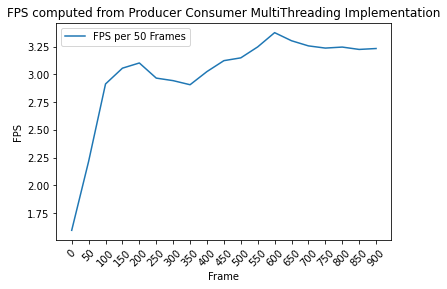

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(0,total_frames+1,50), fps_list, label = 'FPS per 50 Frames')
plt.title('FPS computed from Producer Consumer MultiThreading Implementation')
plt.ylabel('FPS')
plt.xlabel('Frame')
plt.legend()
plt.xticks(range(0,total_frames+1,50),rotation=45)
plt.show()

## Event Extraction Time

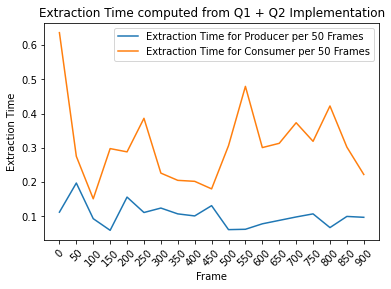

In [23]:
plt.plot(range(0,total_frames+1,50), detection_event_extractions, label = 'Extraction Time for Producer per 50 Frames')
plt.plot(range(0,total_frames+1,50), classification_event_extractions, label = 'Extraction Time for Consumer per 50 Frames')
plt.title('Extraction Time computed from Q1 + Q2 Implementation')
plt.ylabel('Extraction Time')
plt.xlabel('Frame')
plt.legend()
plt.xticks(range(0,total_frames+1,50),rotation=45)
plt.show()

## Throughput Graph

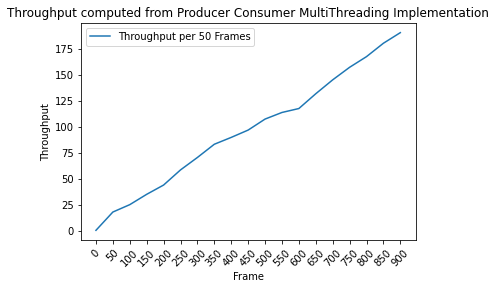

In [24]:
plt.plot(range(0,total_frames+1,50), throughput_time, label = 'Throughput per 50 Frames')
plt.title('Throughput computed from Producer Consumer MultiThreading Implementation')
plt.ylabel('Throughput')
plt.xlabel('Frame')
plt.legend()
plt.xticks(range(0,total_frames+1,50),rotation=45)
plt.show()

## F1 Accuracy

In [20]:
def f1_score(ground_truth_col_name, actual_truth_col_name,csv_file_name):
  actual = pd.read_csv(csv_file_name)
  ground = pd.read_excel('Ground Truth.xlsx')
  
  metrics = pd.concat([ground, actual], axis=1)
  metrics = metrics.apply(pd.to_numeric, errors='coerce')
    
  '''
  Here the main concept is that we cannot use traditional F1 function as here we
  have values and not labels. So for:
  TP - Consider that there were actually 3 cars, but predicted was 2 cars, so it means that
    my system was able to 2 cars correctly so this becomes my TP.
  TN - Is always Zero, as here we are considering only one category not mutliple categories
  FP - Consider that there were actually 3 cars, but predicted was 4 cars, so it means that
    my system falsely categorized 1 thing as car so that extra wrong classification becomes my FP.
  FN - Consider that there were actually 3 cars, but predicted was 2 cars, so it means that
    my system couldn't categorize 1 car present in the image so this missed classification becomes my FN.
  '''
  metrics['TP'] = metrics[[ground_truth_col_name,actual_truth_col_name]].min(axis=1)
  metrics['TN'] = 0
  metrics['FP'] = metrics.apply(lambda m: max(m[actual_truth_col_name]-m[ground_truth_col_name], 0), axis=1)
  metrics['FN'] = metrics.apply(lambda m: max(m[ground_truth_col_name]-m[actual_truth_col_name], 0), axis=1)
  
  metrics['Precision'] = metrics.apply(lambda m: m['TP'] / (m['TP'] + m['FP']), axis=1)
  metrics['Recall'] = metrics.apply(lambda m: m['TP'] / (m['TP'] + m['FN']), axis=1)
  metrics['F1'] = metrics.apply(lambda m: (2*m['Precision']*m['Recall']) / (m['Precision'] + m['Recall']), axis=1)
  
  return metrics['F1'].mean()

In [21]:
import warnings
warnings.filterwarnings('ignore')
print(f"F1 Score for Car per Frame: {f1_score('Total','Car Count',csv_file_name)}")
print(f"F1 Score for Sedan per Frame: {f1_score('Sedan','SEDAN',csv_file_name)}")
print(f"F1 Score for SUV per Frame: {f1_score('SUV','Suv',csv_file_name)}")

F1 Score for Car per Frame: 0.9133722196222239
F1 Score for Sedan per Frame: 0.7985877240630075
F1 Score for SUV per Frame: 0.7917837913432667


# Q1 Execution

In [13]:
# Meta Data needed to create csv file
answer_df = pd.DataFrame()
frames, cars, suvs, sedans, fps_list = [], [], [], [], []
detection_event_extractions, classification_event_extractions, throughput_time = [], [], [] 

#Input the main video file for processing.
video_stream = cv2.VideoCapture('assignment-clip.mp4')
total_frames = int(video_stream.get(cv2.CAP_PROP_FRAME_COUNT))

#Setting Up Config and Weights file of YOLO so that a Deep Neural Net can be
##developed to get bounding boxes.
CONFIG_FILE='yolov3-tiny.cfg'
WEIGHTS_FILE='yolov3-tiny.weights'
csv_file_name='Actual Truth-Q1.csv'

#Load a Deep Neural Net into the cv2 function using config and weights file
net = cv2.dnn.readNet(CONFIG_FILE, WEIGHTS_FILE)
#Fetch the NN Layer for further processing
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

#Final Output Labels
LABELS = ['sedan', 'suv']

#Setting up Video Writer used to create the output video
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
OUTPUT_FILE='KollapudiNagendraDheeraj_ShubhankerBanerjee_Assignment1_Q1_video.mp4'
writer = cv2.VideoWriter(OUTPUT_FILE, fourcc, 30, (428, 576), True)

# Initialize FPS to get FPS value
fps = FPS().start()

queue = Queue()

process_start_time = time.time()

query_type = 'Q1'

pbar = ''
od = ObjectDetection()
od.start()

oc = ObjectClassification()
oc.start()

od.join()
oc.join()

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:29<00:00, 30.63it/s]

Elasped time for processing: 29.38
Approx. FPS: 30.64
[INFO] cleaning up...


## FPS

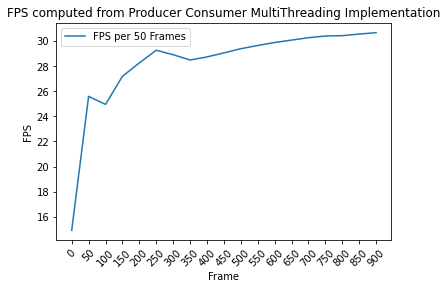

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(0,total_frames+1,50), fps_list, label = 'FPS per 50 Frames')
plt.title('FPS computed from Producer Consumer MultiThreading Implementation')
plt.ylabel('FPS')
plt.xlabel('Frame')
plt.legend()
plt.xticks(range(0,total_frames+1,50),rotation=45)
plt.show()

## Event Extraction Time

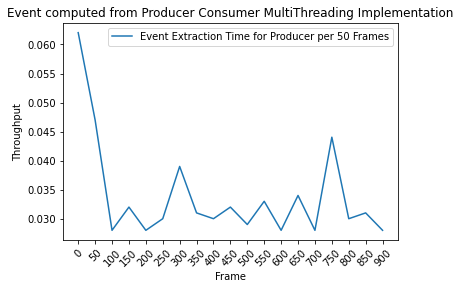

In [15]:
plt.plot(range(0,total_frames+1,50), detection_event_extractions, label = 'Event Extraction Time for Producer per 50 Frames')
plt.title('Event computed from Producer Consumer MultiThreading Implementation')
plt.ylabel('Throughput')
plt.xlabel('Frame')
plt.legend()
plt.xticks(range(0,total_frames+1,50),rotation=45)
plt.show()

## Throughput Graph

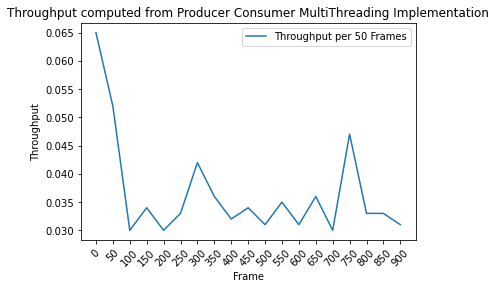

In [16]:
plt.plot(range(0,total_frames+1,50), throughput_time, label = 'Throughput per 50 Frames')
plt.title('Throughput computed from Producer Consumer MultiThreading Implementation')
plt.ylabel('Throughput')
plt.xlabel('Frame')
plt.legend()
plt.xticks(range(0,total_frames+1,50),rotation=45)
plt.show()

## F1 Accuracy

In [17]:
print(f"F1 Score for Car per Frame: {f1_score('Total','Car Count',csv_file_name)}")

F1 Score for Car per Frame: 0.9133722196222239
